In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import os 
import glob
import ast 
from ast import literal_eval
from government_functions import * 
import warnings
warnings.formatwarning = lambda msg, *args, **kwargs: f'{msg}\n'
import statsmodels.api as sm 
import matplotlib.pyplot as plt


In [2]:
final_df=pd.read_excel('results/complete_dataframe.xlsx',index_col=0)
special_cases= []
for csv_file in glob.glob(os.path.join('government/','*.csv')): 
    file= os.path.basename(csv_file)
    countryname,_=os.path.splitext(file)
    #create country government dataframe
    df=process_gov_csv(csv_file)
    #grab part of final_df that is relevant for the country
    country_df=final_df[[col for col in final_df.columns if col.startswith(countryname)]] #this is case sensitive... 
    elections=country_df.columns.to_numpy() # list of elections in the country
    election_period_dict=match_ministries_and_elections(countryname,elections,df)
    #subset election_df's for only the first (probable) set of appointed ministers in an election period (initial government) --> see function description and text 
    government_dict,edge_cases=starting_gov_dict(election_period_dict,countryname)
    special_cases.extend(edge_cases)
    ##loop over all election periods: ##
    for date,dataframe in government_dict.items():
        if not dataframe.empty:
            party_str=country_df.at['parties',f'{countryname}{date}']
            parties=ast.literal_eval(party_str) # parses string to list  
            #create dicts
            ministry_dict,unweighted_dict,weighted_dict,primeminister_dict,endo_dict=get_ministry_dicts(dataframe,parties) 
            fuzzy_ministry_dict,fuzzy_unweighted_dict,fuzzy_weighted_dict,fuzzy_primeminister_dict=get_fuzzy_ministry_dicts(dataframe,parties) 
            #initiate lists / arrays corrosponding to the party list     
            primeminister_array=np.zeros(len(parties))  
            fuzzyprime_array=np.zeros(len(parties))  
            ministy_list=[]
            fuzzy_min_list=[]
            unweighted_array=np.zeros(len(parties))  
            endo_array=np.zeros(len(parties))  
            weighted_array=np.zeros(len(parties))
            fuzzy_unweighted_array=np.zeros(len(parties))  
            fuzzy_weighted_array=np.zeros(len(parties))  
            #fill lists / arrays from dict entries
            for i,(party,value) in enumerate(primeminister_dict.items()):
                primeminister_array[i]=value
            for i,(party,value) in enumerate(fuzzy_primeminister_dict.items()):
                fuzzyprime_array[i]=value
            for i,(party,value) in enumerate(ministry_dict.items()): 
                ministy_list.append(value)
            for i,(party,value) in enumerate(unweighted_dict.items()):
                unweighted_array[i]=value
            for i,(party,value) in enumerate(endo_dict.items()):
                endo_array[i]=value    
            for i,(party,value) in enumerate(weighted_dict.items()):
                weighted_array[i]=value
            for i,(party,value) in enumerate(fuzzy_ministry_dict.items()): 
                fuzzy_min_list.append(value)
            for i,(party,value) in enumerate(fuzzy_unweighted_dict.items()):
                fuzzy_unweighted_array[i]=value
            for i,(party,value) in enumerate(fuzzy_weighted_dict.items()):
                fuzzy_weighted_array[i]=value    
            #write country name: 
            if 'Country' not in final_df.index: 
                final_df.loc['Country']=[np.nan] * len(final_df.columns)  
            final_df.at['Country',f'{countryname}{date}']= countryname
            # write list/arrays to final_df:
            if 'Primeminister' not in final_df.index: 
                final_df.loc['Primeminister']=[np.nan] * len(final_df.columns)   
            if 'Ministers' not in final_df.index: 
                final_df.loc['Ministers']=[np.nan] * len(final_df.columns)   
            if 'unweighted' not in final_df.index: 
                final_df.loc['unweighted']=[np.nan] * len(final_df.columns)   
            if 'endo' not in final_df.index: 
                final_df.loc['endo']=[np.nan] * len(final_df.columns)       
            if 'weighted' not in final_df.index: 
                final_df.loc['weighted']=[np.nan] * len(final_df.columns) 
            final_df.at['Primeminister',f'{countryname}{date}']=primeminister_array    
            final_df.at['Ministers',f'{countryname}{date}']=ministy_list
            final_df.at['unweighted',f'{countryname}{date}']=unweighted_array
            final_df.at['endo',f'{countryname}{date}']=endo_array
            final_df.at['weighted',f'{countryname}{date}']=weighted_array 
            
            # write fuzzy list/arrays to final_df:
            if 'fuzzy_Primeminister' not in final_df.index: 
                final_df.loc['fuzzy_Primeminister']=[np.nan] * len(final_df.columns)   
            if 'fuzzy_Ministers' not in final_df.index: 
                final_df.loc['fuzzy_Ministers']=[np.nan] * len(final_df.columns)   
            if 'fuzzy_unweighted' not in final_df.index: 
                final_df.loc['fuzzy_unweighted']=[np.nan] * len(final_df.columns)   
            if 'fuzzy_weighted' not in final_df.index: 
                final_df.loc['fuzzy_weighted']=[np.nan] * len(final_df.columns) 
            final_df.at['fuzzy_Primeminister',f'{countryname}{date}']=fuzzyprime_array    
            final_df.at['fuzzy_Ministers',f'{countryname}{date}']=fuzzy_min_list
            final_df.at['fuzzy_unweighted',f'{countryname}{date}']=fuzzy_unweighted_array
            final_df.at['fuzzy_weighted',f'{countryname}{date}']=fuzzy_weighted_array 



Australia-Aug-10: Use government from 2010-09-14 00:00:00
Australia--Sep-13: Careful, check db error. Found Government at 2013-08-31 00:00:00
Australia-Jul-16: Use government from 2016-07-19 00:00:00
Austria-Sep-19: Use government from 2020-01-07 00:00:00
Belgium--Nov-91: Careful, check db error. Found Government at 1991-10-03 00:00:00
Bulgaria-Oct-14: Use government from 2014-11-07 00:00:00
Croatia-Nov-07: No suitable government found within a year after the election. Fall back to late government at 2009-07-01 00:00:00.
Cyprus-May-01: No suitable government found within a year after the election. Fall back to late government at 2003-02-28 00:00:00.
Cyprus-May-06: Use government from 2006-07-16 00:00:00
Cyprus--May-06: Only found 4 ministers.
Cyprus-May-11: Use government from 2011-08-05 00:00:00
Cyprus--May-11: Only found 7 ministers.
Cyprus-May-16: No suitable government found within a year after the election. Fall back to late government at 2018-03-01 00:00:00.
Czech-Jun-02: Use gov

## Monte Carlo Study of Formateurs

This code aims to introduce two dummy variables per parliament,indicating who would be formateur, if formateurs where either drawn with equal probability across parties or with probabilities proportional to their seat share. 

In [3]:
#subset relevant indices 
rel_indices= ['mvws','Seats','unweighted']
df=final_df.loc[rel_indices]
df=df.dropna(axis=1,how='any')
indice=['mvws']
df.loc[indice]=df.loc[indice].applymap(ast.literal_eval).applymap(np.array)
df.loc['mvw-i']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['gov_share']=df.loc['unweighted'].apply(lambda x:x/np.sum(x))
for col in df.columns: 
    if np.any(np.isclose(df.loc['mvw-i',col],1)): 
        df.drop(col,axis=1,inplace=True)
for col in df.columns:     
    if np.any(np.isclose(df.loc['gov_share',col],1)):
        df.drop(col,axis=1,inplace=True)


In [4]:
#add q and \gamma_1 as well as \gamma_2 to the df
def get_q(mvws):
    if isinstance (mvws,str): 
        mvws = ast.literal_eval(mvws)
    mvws= np.array(mvws, dtype=float)
    W_bb=np.sum(mvws)
    q=(W_bb+1)//2 # // is equivalent to floor()
    return q

q_values=df.loc['mvws'].apply(get_q)
df.loc['q']=q_values

In [5]:
#test for n^J>\frac{W-q}{min w_t}
def get_crit_n(mvws):
    #returns boolean int whether n^J is large enough 
    if isinstance (mvws,str): 
        mvws = ast.literal_eval(mvws)
    mvws= np.array(mvws, dtype=float)
    W_bb=np.sum(mvws)
    q=(W_bb+1)//2
    n_J=len(mvws)
    min_t=np.min(mvws)
    if min_t== 0: 
        return 0
    if n_J>(W_bb-q)/min_t: 
        return 1
    else: return 0
#write boolean to df
crit_n_values=df.loc['mvws'].apply(get_crit_n)
df.loc['crit_n']=crit_n_values

In [6]:
#add  \gamma^prop as well as \gamma^uni to the df
def get_lambdas(mvws): 
    if isinstance (mvws,str): 
        mvws = ast.literal_eval(mvws)
    mvws= np.array(mvws, dtype=float)
    W_bb=np.sum(mvws)
    q=(W_bb+1)//2
    lambda_prop_arr=np.zeros(len(mvws))
    lambda_uni_arr=np.zeros(len(mvws))
    for j in range(len(mvws)):
        if W_bb!= mvws[j]:
            lambda_prop=(q-mvws[j])/(W_bb-mvws[j])
            lambda_prop_arr[j]=lambda_prop
        else: lambda_prop_arr[j]=np.nan
        if mvws[j]!=0: 
            lambda_uni=1-(W_bb-q)/((len(mvws)-1)*mvws[j])
            lambda_uni_arr[j]=lambda_uni
        else: lambda_uni_arr[j]=np.nan
    return lambda_prop_arr,lambda_uni_arr
        

In [7]:
df.loc['lambda_prop']=None
df.loc['lambda_uni']=None
for col in df.columns: 
    lambda_prop_values,lambda_uni_values=get_lambdas(df.loc['mvws',col])
    df.at['lambda_prop',col]=lambda_prop_values
    df.at['lambda_uni',col]=lambda_uni_values



In [8]:
def normalize_lists(list): 
    ##function to convert str to list where necessary and then normalize values 
    if isinstance (list,str): 
        list = ast.literal_eval(list)
    vec= np.array(list, dtype=float)
    normal_vec=vec/vec.sum()
    return normal_vec

In [9]:
#apply normalize_lists to seats
for col in df.columns: 
    df.at['Seats',col]= normalize_lists(df.at['Seats',col])
    

In [11]:
## export to r: 
monte_carlo_data= [] 
for col in final_df.columns:
    try:
        crit_n=df[col]['crit_n']
        for counting, (seats,mvw_i,gov_share,lambda_prop,lambda_uni) in enumerate(zip(df[col]['Seats'],df[col]['mvw-i'],df[col]['gov_share'],df[col]['lambda_prop'],df[col]['lambda_uni'])): 
            monte_carlo_data.append({'Parliament': col, 'Party': counting,'Seats':seats, 'mvw_i': mvw_i,'gov_share':gov_share,'lambda_prop':lambda_prop,'lambda_uni':lambda_uni,'crit_n':crit_n})
    except KeyError: pass        
monte_carlo_df=pd.DataFrame(monte_carlo_data)
import pyarrow.feather as feather
feather.write_feather(monte_carlo_df,"monte_carlo_df.feather")

In [6]:
def draw_formateurs(seats): 
    ## draws a random formateur party, once following a proportional chance from the seats and once following a uniform distribution. 
    ## inputs a list of seats 
    ## outputs 2 lists
    
    # ensure probabiltiy form 
    seats = np.array(seats)/np.sum(seats)
    
    #position of formateur: 
    index_proportional = np.random.choice(range(len(seats)),p=seats) 
    index_uniform = np.random.choice(range(len(seats))) 
    
    #generate dummy variable lists
    proportional_list = [0]*len(seats)
    uniform_list=[0]*len(seats)
    proportional_list[index_proportional] = 1
    uniform_list[index_uniform] = 1 
    return proportional_list,uniform_list

In [7]:
def ols_data_collection(df): 
    seat_list = []
    mvw_list = []
    prop_formateur_list = []
    uniform_formateur_list = []
    unweighted_ministries_list = []
    # draw formateur status and collect variables 
    for col in df.columns: 
        seats = df.loc['Seats',col]
        mvws = df.loc['mvws',col]
        if not np.any(np.isclose(mvws,1)): #check for absolute majoritys: 
            ministry_list= df.loc['unweighted',col]  
            if not np.any(np.isclose(ministry_list,1)) and np.sum(ministry_list)>0 : #check for (singly party) minority governments and empty entries: 
                proportional_list,uniform_list= draw_formateurs(mvws)
                seat_list.extend(seats)
                mvw_list.extend(mvws)
                unweighted_ministries_list.extend(ministry_list)
                prop_formateur_list.extend(proportional_list)
                uniform_formateur_list.extend(uniform_list)
    return seat_list,mvw_list,prop_formateur_list,uniform_formateur_list,unweighted_ministries_list

In [8]:
def monte_carlo(df,num=500, do_print= False): 
    results_proportional= []
    results_uniform= []
    a=0
    while a in range(num): 
        seat_list,mvw_list,prop_formateur_list,uniform_formateur_list,unweighted_ministries_list = ols_data_collection(df)
        # ols 
        X_proportional = np.column_stack((mvw_list,prop_formateur_list)) # create design-matrix 
        X_proportional = sm.add_constant(X_proportional) 
        X_uniform = np.column_stack((mvw_list,uniform_formateur_list))
        X_uniform = sm.add_constant(X_uniform)
        Y = np.array(unweighted_ministries_list)
        proportional_model = sm.regression.linear_model.OLS(Y,X_proportional,missing='drop').fit()
        uniform_model = sm.regression.linear_model.OLS(Y,X_uniform,missing='drop').fit()
        if a % 100 == 0 and do_print: 
            print(proportional_model.summary())
        results_proportional.append({            
            'params': proportional_model.params,
            'p*': proportional_model.pvalues,
            'r^2': proportional_model.rsquared,})
        results_uniform.append({            
            'params': uniform_model.params,
            'p*': uniform_model.pvalues,
            'r^2': uniform_model.rsquared,})
        #if do_print: print(a)
        a += 1
    return results_proportional,results_uniform
        


In [9]:
results_proportional,results_uniform = monte_carlo(df,num=5000,do_print=False)

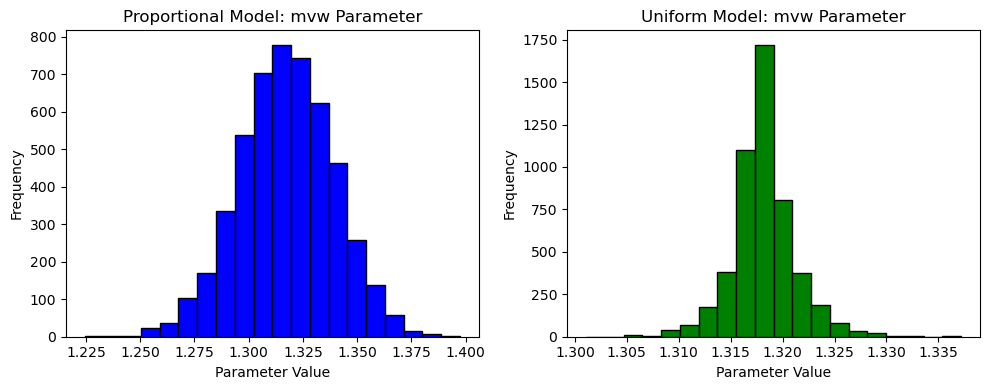

In [10]:
mvw_values_proportional = [result['params'][1] for result in results_proportional]
mvw_values_uniform = [result['params'][1] for result in results_uniform]

# Plot histogram for 'mvw' parameter in proportional models
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(mvw_values_proportional, bins=20, color='blue', edgecolor='black')
plt.title('Proportional Model: mvw Parameter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')

# Plot histogram for 'mvw' parameter in uniform models
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(mvw_values_uniform, bins=20, color='green', edgecolor='black')
plt.title('Uniform Model: mvw Parameter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


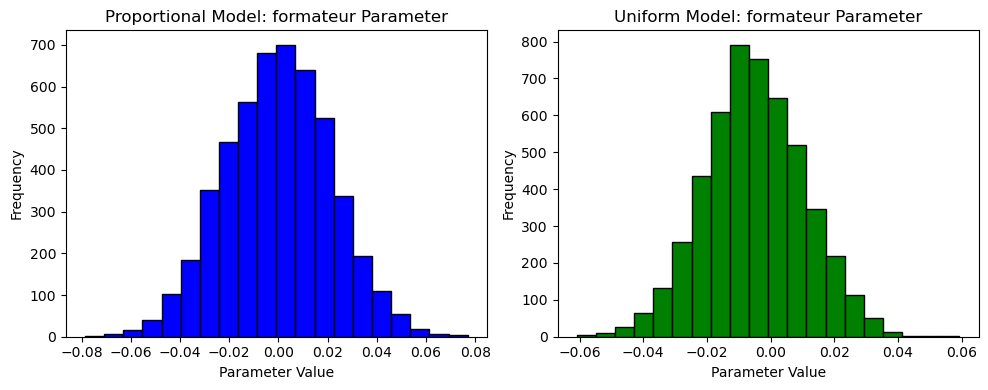

In [11]:
formateur_values_proportional = [result['params'][2] for result in results_proportional]
formateur_values_uniform = [result['params'][2] for result in results_uniform]

# Plot histogram for 'mvw' parameter in proportional models
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(formateur_values_proportional, bins=20, color='blue', edgecolor='black')
plt.title('Proportional Model: formateur Parameter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')

# Plot histogram for 'mvw' parameter in uniform models
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(formateur_values_uniform, bins=20, color='green', edgecolor='black')
plt.title('Uniform Model: formateur Parameter')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


In [12]:
# Initialize p value counters
ten_percent_prop = 0
five_percent_prop = 0
one_percent_prop = 0

ten_percent_uniform = 0
five_percent_uniform = 0
one_percent_uniform = 0

### proportional formateur estiamtes ####
for result in results_proportional:
    pvalue = result['p*'][-1]  # Accessing the last p-value, corresponding to the formateur coefficient
    if pvalue < 0.01:
        one_percent_prop += 1
        five_percent_prop += 1  
        ten_percent_prop += 1  
    elif pvalue < 0.05:
        five_percent_prop += 1
        ten_percent_prop += 1
    elif pvalue < 0.1:
        ten_percent_prop += 1
### uniform formateur estimates #####
for result in results_uniform:
    pvalue = result['p*'][-1] 
    if pvalue < 0.01:
        one_percent_uniform += 1
        five_percent_uniform += 1 
        ten_percent_uniform += 1  
    elif pvalue < 0.05:
        five_percent_uniform += 1
        ten_percent_uniform += 1
    elif pvalue < 0.1:
        ten_percent_uniform += 1

# Calculate percentages
total_results = len(results_proportional)
percentages_proportional = {
    '<0.01': (one_percent_prop / total_results) * 100,
    '<0.05': (five_percent_prop / total_results) * 100,
    '<0.1': (ten_percent_prop / total_results) * 100,
}

percentages_uniform = {
    '<0.01': (one_percent_uniform / total_results) * 100,
    '<0.05': (five_percent_uniform / total_results) * 100,
    '<0.1': (ten_percent_uniform / total_results) * 100,
}

# Print
print("Proportional model p-value percentages for the formateur coefficient:")
print(percentages_proportional)
print("Uniform model p-value percentages for the formateur coefficient:")
print(percentages_uniform)


Proportional model p-value percentages for the formateur coefficient:
{'<0.01': 8.64, '<0.05': 18.92, '<0.1': 27.6}
Uniform model p-value percentages for the formateur coefficient:
{'<0.01': 2.94, '<0.05': 10.16, '<0.1': 16.580000000000002}


## Export to R 

In [13]:
rel_indices= ['mvws','Seats','Penrose-Banzhaf','Shapely-Shubik','Primeminister','unweighted','endo','weighted','Country']#,'fuzzy_Primeminister','fuzzy_unweighted','fuzzy_weighted']
df=final_df.loc[rel_indices]
df=df.dropna(axis=1,how='any')
indice=['mvws','Seats','Penrose-Banzhaf','Shapely-Shubik']
df.loc[indice]=df.loc[indice].applymap(ast.literal_eval).applymap(np.array)
df.loc['mvws']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['Seats']=df.loc['Seats'].apply(lambda x:x/np.sum(x))
df.loc['unweighted']=df.loc['unweighted'].apply(lambda x:x/np.sum(x))
df.loc['endo']=df.loc['endo'].apply(lambda x:x/np.sum(x))
df.loc['weighted']=df.loc['weighted'].apply(lambda x:x/np.sum(x))
#df.loc['fuzzy_unweighted']=df.loc['fuzzy_unweighted'].apply(lambda x:x/np.sum(x))
#df.loc['fuzzy_weighted']=df.loc['fuzzy_weighted'].apply(lambda x:x/np.sum(x))


In [14]:
##exclude absolute majority parliaments: 
coal_parliaments = []
count_absolute_majorities = 0
for col in df.columns: 
    mvws= df.loc['mvws',col]
    if np.any(np.isclose(mvws,1)): 
        count_absolute_majorities += 1
    else: coal_parliaments.append(col)
df=df[coal_parliaments]

exclude and count number of miniority governments

In [15]:
majority_governments = []
count_minority_governments = 0 
for col in df.columns: 
    gov_percent= df.loc['unweighted',col]
    
    if np.any(np.isclose(gov_percent,1)):
        count_minority_governments += 1  
    else:   majority_governments.append(col)
df=df[majority_governments]

In [16]:
long_data= []
for col in final_df.columns: 
    try:
        country= df[col]['Country']
        for counting, (mvw,seats,pbs,sss,pm,unweighted,endo,weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['Penrose-Banzhaf'],df[col]['Shapely-Shubik'],df[col]['Primeminister'],df[col]['unweighted'],df[col]['endo'],df[col]['weighted'])): 
            long_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'PB-I':pbs,'SS-I':sss,'pm':pm,'unweighted_ministries':unweighted,'endo':endo,'weighted_ministries':weighted,'Country':country})
    except KeyError: pass        
## including fuzzy matching:     
""" for col in final_df.columns: 
    try:
        country= df[col]['Country']
        for counting, (mvw,seats,pbs,sss,pm,unweighted,endo,weighted,fuzzy_pm,fuzzy_unweighted,fuzzy_weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['Penrose-Banzhaf'],df[col]['Shapely-Shubik'],df[col]['Primeminister'],df[col]['unweighted'],df[col]['endo'],df[col]['weighted'],df[col]['fuzzy_Primeminister'],df[col]['fuzzy_unweighted'],df[col]['fuzzy_weighted'])): 
            long_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'PB-I':pbs,'SS-I':sss,'pm':pm,'unweighted_ministries':unweighted,'endo':endo,'weighted_ministries':weighted,'fuzzy_pm':fuzzy_pm,'fuzzy_unweighted_ministries':fuzzy_unweighted,'fuzzy_weighted_ministries':fuzzy_weighted,'Country':country})
    except KeyError: pass  """
long_df=pd.DataFrame(long_data)

In [17]:
""" os.environ['R_HOME']="C:\Program Files\R\R-4.3.3"
import rpy2.robjects as robj
from rpy2.robjects import pandas2ri
pandas2ri.activate()
robj.globalenv['df_to_r']=long_df
 """
import pyarrow.feather as feather
feather.write_feather(long_df,"new_long_df.feather")

In [ ]:
df = pd.read_feather('long_df.feather')

end of export 

In [ ]:
for name in list(globals()): 
    if name != 'final_df':
        del globals()[name]

## Scatter Plot Seat Share vs MVWs

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import ast 
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from government_functions import * 


In [ ]:

df=final_df.loc['mvws':'Seats']
df=df.applymap(ast.literal_eval)
df=df.applymap(np.array)
df.loc['mvws']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['Seats']=df.loc['Seats'].apply(lambda x:x/np.sum(x))
plot_data= []
for col in final_df.columns: 
    for counting, (mvw,seats) in enumerate(zip(df[col]['mvws'],df[col]['Seats'])): 
        plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats})
plot_df=pd.DataFrame(plot_data)
    

In [ ]:
plt.figure(figsize=(10,6))
for parliament, zipped_data in plot_df.groupby('Parliament'): 
    plt.scatter(zipped_data['Seats'],zipped_data['mvw'])
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plot_df=plot_df[plot_df['mvw']<1]
for parliament, zipped_data in plot_df.groupby('Parliament'): 
    plt.scatter(zipped_data['Seats'],zipped_data['mvw'])
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()

In [ ]:
rel_indices= ['mvws','Seats','unweighted','weighted']
df=final_df.loc[rel_indices]
df=df.dropna(axis=1,how='any')

In [ ]:
plot_data= []
indice=['mvws','Seats']
df.loc[indice]=df.loc[indice].applymap(ast.literal_eval).applymap(np.array)
df.loc['mvws']=df.loc['mvws'].apply(lambda x:x/np.sum(x))
df.loc['Seats']=df.loc['Seats'].apply(lambda x:x/np.sum(x))
df.loc['unweighted']=df.loc['unweighted'].apply(lambda x:x/np.sum(x))
df.loc['weighted']=df.loc['weighted'].apply(lambda x:x/np.sum(x))
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted Ministries':unweighted,'weighted Ministries':weighted})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='Seats', y='mvw')
plt.xlabel('Party Weights in Parliaments (Seats)')
plt.ylabel('Minimal Voting Weights (MVWs)')
plt.show()


In [ ]:

plot_data= []
share_in_gov=[]
for col in df.columns: 
    seats= df.loc['Seats',col]
    unweighted=df.loc['unweighted',col]
    in_gov_mask=unweighted>0 
    size_of_gov=np.sum(seats[in_gov_mask])
    share_in_gov_col=np.zeros_like(seats)
    share_in_gov_col[in_gov_mask]=seats[in_gov_mask]/size_of_gov
    share_in_gov.append(share_in_gov_col)
df.loc['% in gov',:]= share_in_gov
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted,gov_share) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'],df[col]['% in gov'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted Ministries':unweighted,'weighted Ministries':weighted,'gov_share':gov_share})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plot_df=plot_df[plot_df['gov_share']>0]
plot_df=plot_df[plot_df['gov_share']<1]
plot_df=plot_df[plot_df['mvw']<1]
plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='gov_share', y='mvw')
plt.xlabel('Relative Party Weights in Government')
plt.ylabel('Minimal Voting Weights (MVWs) in Parliament')
plt.title('Replication Figure 1')
plt.show()

## Scatter Plot Seat Share ~ Ministries & MVW ~ Ministries

In [ ]:
plot_data= []
for col in final_df.columns: 
    try:
        for counting, (mvw,seats,unweighted,weighted) in enumerate(zip(df[col]['mvws'],df[col]['Seats'],df[col]['unweighted'],df[col]['weighted'])): 
            plot_data.append({'Parliament': col, 'Party': counting, 'mvw': mvw,'Seats':seats,'unweighted_ministries':unweighted,'weighted_ministries':weighted})
    except KeyError: pass        
plot_df=pd.DataFrame(plot_data)
plot_df.dropna(subset=['unweighted_ministries'],inplace=True)
plot_df=plot_df[plot_df['mvw']<1]
plot_df=plot_df[plot_df['unweighted_ministries']>0]
plot_df=plot_df[plot_df['weighted_ministries']<1]

In [ ]:
fig,axes= plt.subplots(2,2,figsize=(12,12))
###data:
sns.scatterplot(data=plot_df, x='mvw', y='unweighted_ministries', ax=axes[0, 0])
sns.scatterplot(data=plot_df, x='Seats', y='unweighted_ministries', ax=axes[0, 1])
sns.scatterplot(data=plot_df, x='mvw', y='weighted_ministries', ax=axes[1, 0])
sns.scatterplot(data=plot_df, x='Seats', y='weighted_ministries', ax=axes[1, 1])
### labels: 
axes[0, 0].set_title('Unweighted vs. MVW')
axes[0, 0].set_xlabel('MVW')
axes[0, 0].set_ylabel('Unweighted')

axes[0, 1].set_title('Unweighted vs. Seats')
axes[0, 1].set_xlabel('Seats')
axes[0, 1].set_ylabel('Unweighted')

axes[1, 0].set_title('Weighted vs. MVW')
axes[1, 0].set_xlabel('MVW')
axes[1, 0].set_ylabel('Weighted')

axes[1, 1].set_title('Weighted vs. Seats')
axes[1, 1].set_xlabel('Seats')
axes[1, 1].set_ylabel('Weighted')

### plot
plt.tight_layout()
plt.show()

# Regressions

2 approaches: OLS vs Logit

## OLS

See especially from the last 4 diagrams above that the relationship between Seats (or minmal voting weights) and the "score", meaning the number of ministries, seems to be generally positive and there is no reason to assume non-linearity. The data however looks to be heteroscedastic. 

I will thus later account for heteroscedastic errors:

In [ ]:
import statsmodels.api as sm 
import patsy
from patsy import dmatrices## allows "r-like" expressions to be used with statsmodels

In [ ]:
formula_unweighted_mvw='unweighted_ministries ~ mvw'
formula_weighted_mvw='weighted_ministries ~ mvw'
formula_unweighted_seats='unweighted_ministries ~ Seats'
formula_weighted_mvw='weighted_ministries ~ Seats'

In [ ]:
ols_unweighted_mvw=sm.OLS.from_formula(formula=formula_unweighted_mvw,data=plot_df)

In [ ]:
ols_unweighted_mvw_results=ols_unweighted_mvw.fit()
print(ols_unweighted_mvw_results.summary())

In [ ]:
## printing errors: 
y_matrix,x_matrix=dmatrices(formula_unweighted_mvw,plot_df,return_type='dataframe') # get design matrices
y_hat=ols_unweighted_mvw_results.predict(x_matrix) # y_hat as predicted from design matrix
#plot
plt.title('heteroscedasticity for unweighted~mvw')
plt.xlabel('y_hat')
plt.ylabel('residuals')
plt.scatter(y_hat,ols_unweighted_mvw_results.resid)
plt.show()

heteroscedasticity seems to be limited

In [ ]:
ols_unweighted_seats=sm.OLS.from_formula(formula=formula_unweighted_seats,data=plot_df)
ols_unweighted_seats_results=ols_unweighted_seats.fit()
print(ols_unweighted_seats_results.summary())

In [ ]:
## printing errors: 
y_matrix_2,x_matrix_2=dmatrices(formula_unweighted_seats,plot_df,return_type='dataframe') # get design matrices
y_hat_2=ols_unweighted_seats_results.predict(x_matrix_2) # y_hat as predicted from design matrix
#plot
plt.title('heteroscedasticity for unweighted~seats')
plt.xlabel('y_hat_2')
plt.ylabel('residuals_2')
plt.scatter(y_hat_2,ols_unweighted_seats_results.resid)
plt.show()

there seems to be more heteroscedasticity when using seat share rather than voting weights 

the following regressions correct for possibly heteroscdastic standard errors:

In [ ]:
## standard het. consistent errors: 
ols_unweighted_seats_hc0_results = ols_unweighted_seats.fit(cov_type='HC0')
print(ols_unweighted_seats_hc0_results.summary())
## het. consisitend std.errors for small samples:  
ols_unweighted_seats_hc3_results = ols_unweighted_seats.fit(cov_type='HC3')
print(ols_unweighted_seats_hc3_results.summary())

In [ ]:
ols_unweighted_mvw__hc0_results=ols_unweighted_mvw.fit(cov_type='HC0')
print(ols_unweighted_mvw__hc0_results.summary())

generally all ols specifications do not allow for any preference of voting power of seat share even for the restricted set of observations used here.